# Density contrast cross validation
The choice of the density value used in the inversion directly affects the results and therefore needs to be carefully chosen. Choosing too high of a density contrast will result in a low amplitude topography, and too low of a value will result in a topography with high amplitude features. Similar to choosing an optimal damping value in `damping_cross_validation.ipynb`, we provides some tools to best choose the density contrast value.

However, this cross validation is slightly different than the damping cross validation in that we need at least 1 location where we know the true topography. These locations could be from seismic surveys, drill sites etc. These points of known topography are referred to as `constraint points`.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle

import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Create observed gravity data

### True topography

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.262348539866753 m


INFO:invert4geom:Standard deviation used for noise: [0.2]


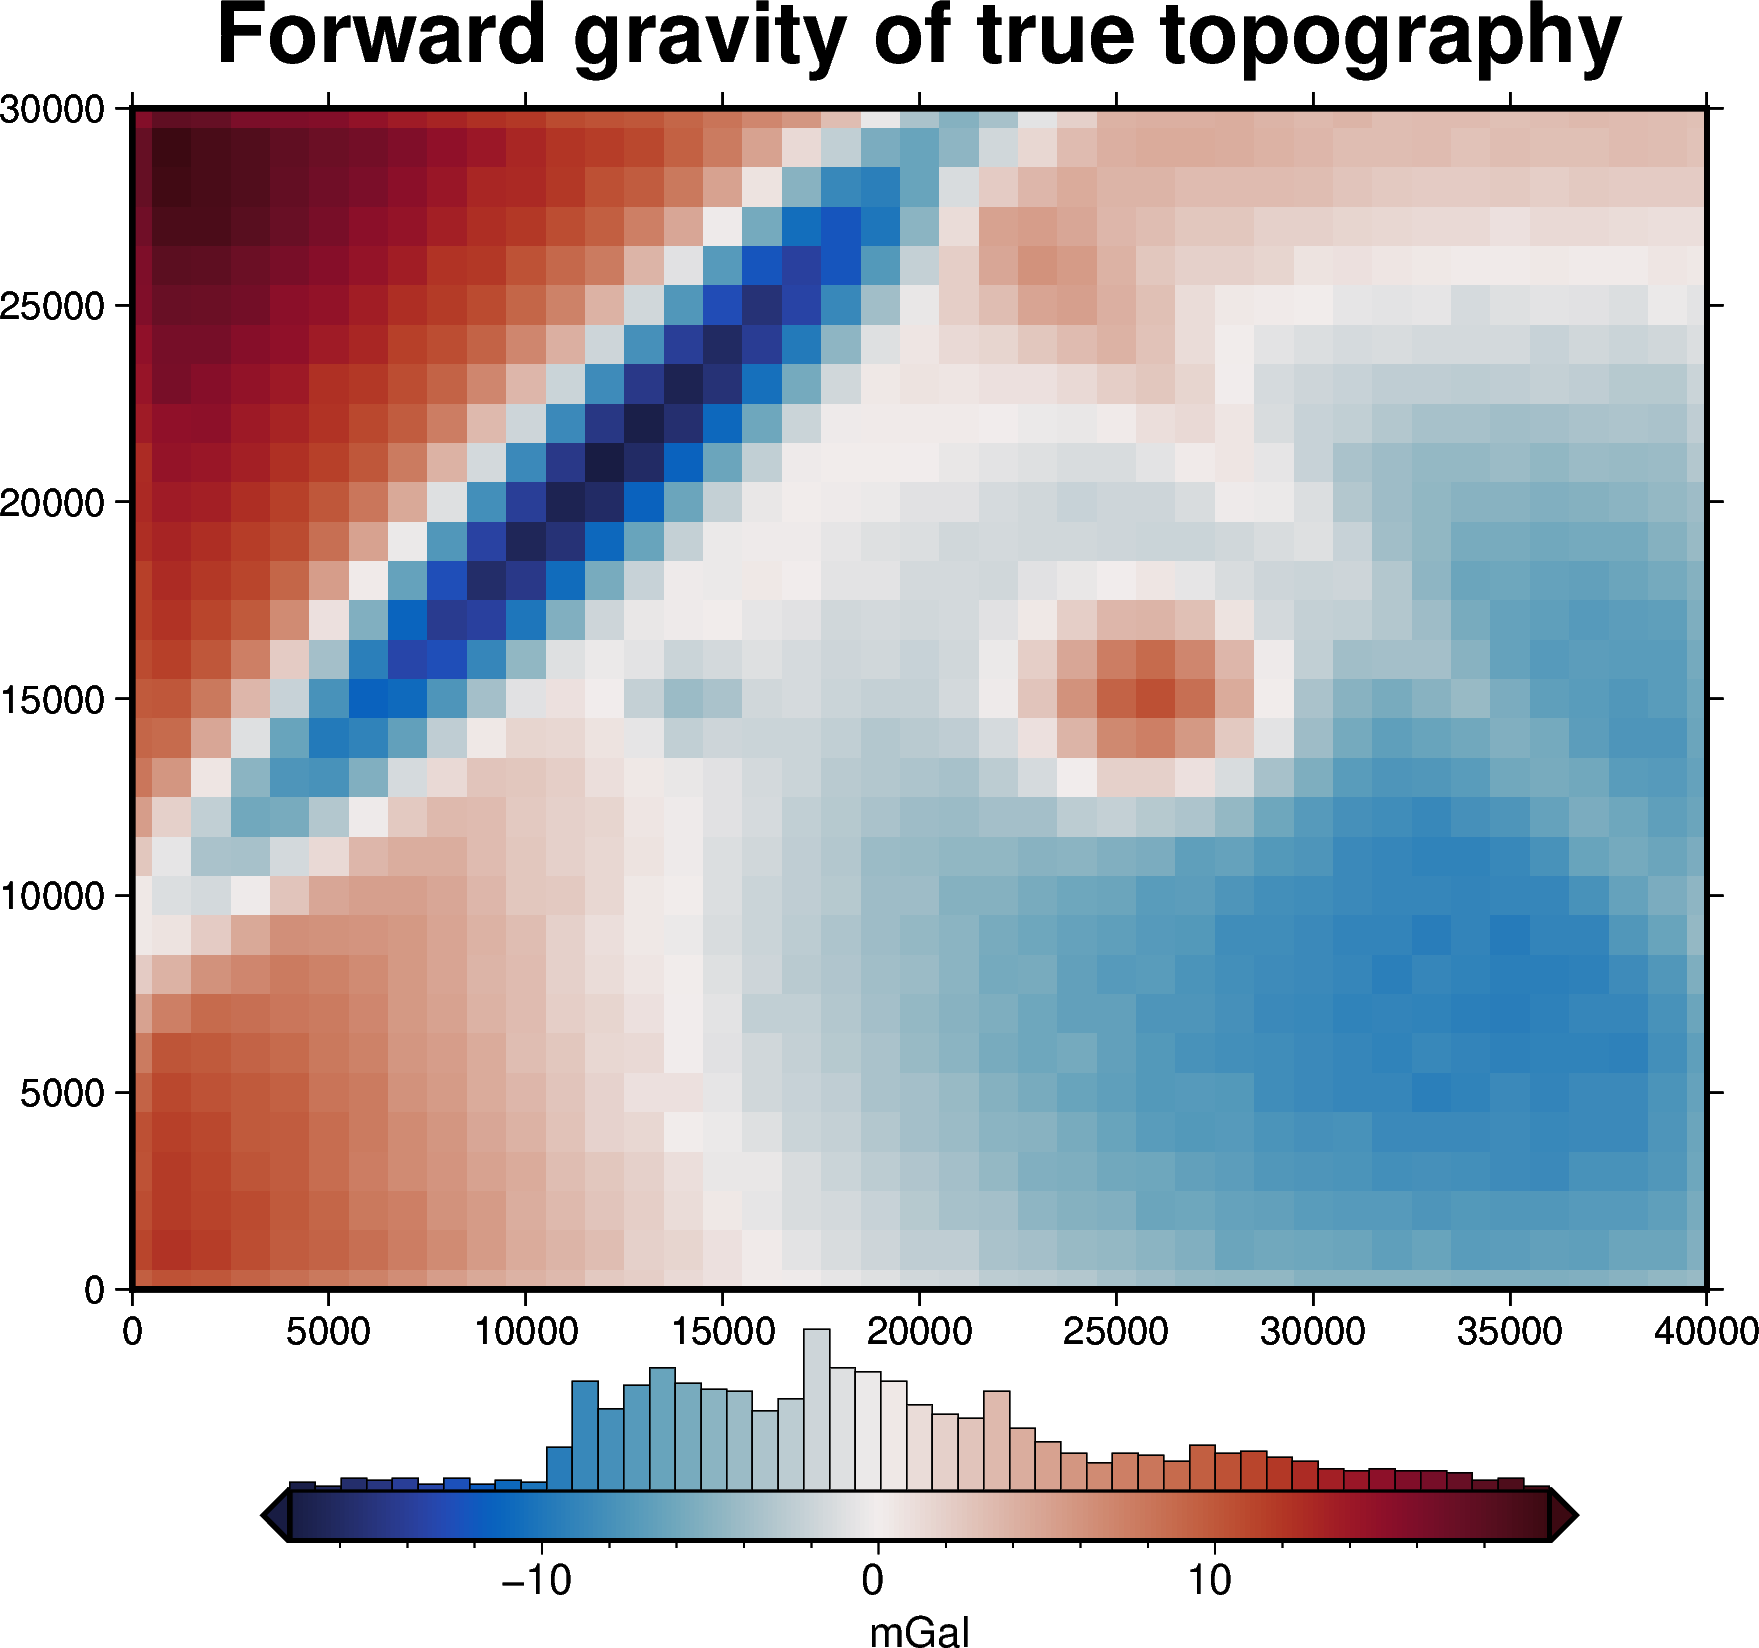

mean of true topography: 492.2704164812973 m 


In [2]:
# set grid parameters
spacing = 1000
region = (0, 40000, 0, 30000)

# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

(
    true_topography,
    _,
    constraint_points,
    grav_df,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    number_of_constraints=10,
    density_contrast=true_density_contrast,
    plot_topography_diff=False,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

For simplicity here we assume that we know reference level `zref` of the true topography, and use this when creating our starting model.

What we don't know in this scenario is what value to use for the density contrast. We will use a cross-validation of a range of density values to find the one which is optimal.

Each density value will give a cross validation score, and the lowest score will show which density value is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points. 

## Get Cross Validation Score

First we need to use the density value to create the flat starting model. We will then use this in an inversion to calculate a `score`.


In [3]:
# set a density contrast
density_contrast = 2300  # compared to true value of 2669

# assume we know the optimal zref value
zref = true_zref

# # create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# since our starting model is flat, the starting gravity is 0
grav_df["starting_gravity"] = 0

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_df = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df,
)

# set kwargs to pass to the inversion
kwargs = {
    "solver_damping": 0.1,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.45,  # gravity error is .2 mGal or L2-norm of ~0.45
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score
score, _ = cross_validation.constraints_cv_score(
    grav_df=grav_df,
    prism_layer=starting_prisms,
    constraints_df=constraint_points,
    **kwargs,
)
print(f"CV score: {score}")

CV score: 11.66990483808958


## Cross Validation
Lets see if we can improve the score with other values for the density contrast. For each density contrast value we need to recreate the starting prism model, forward calculate its starting gravity, and recalculate the gravity misfit, including the regional and residual components. Then we can re-run the inversion.

This is a classic optimization problem, where we vary the density contrast to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, `optimize_inversion_zref_density_contrast` will use a sampler to choose density contrast values between the provided `density_contrast_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test density contrast values at a constant interval, you can set `grid_search` to True, and this will test all damping values as defined by:

```python
np.linspace(<<lower density contrast limit>>, <<upper density contrast limit>>, n_trials)
```

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 


INFO:invert4geom:	trial number: 4


INFO:invert4geom:	parameter: {'density_contrast': 2674}


INFO:invert4geom:	scores: [2.5203013502644454]


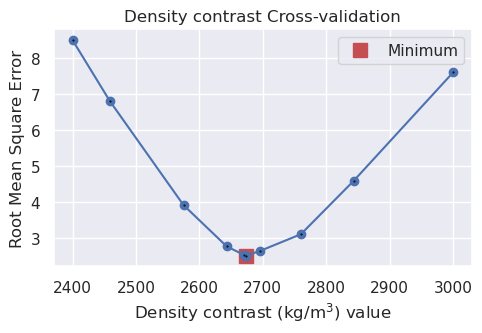

In [4]:
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast_limits=[2400, 3000],
    zref=true_zref,
    n_trials=10,
    starting_topography=starting_topography,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    # grid_search=True,
    fname="../tmp/density_contrast_CV",
    **kwargs,
)

In [5]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/density_contrast_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/density_contrast_CV_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

Lets see how the cross-validation perform by comparing the estimated `best` density value to the true density value used to calculate the observed gravity

In [6]:
print(
    f"True density contrast: {true_density_contrast}, "
    f"best density contrast from CV: {study.best_params.get("density_contrast")}"
)

True density contrast: 2669, best density contrast from CV: 2674


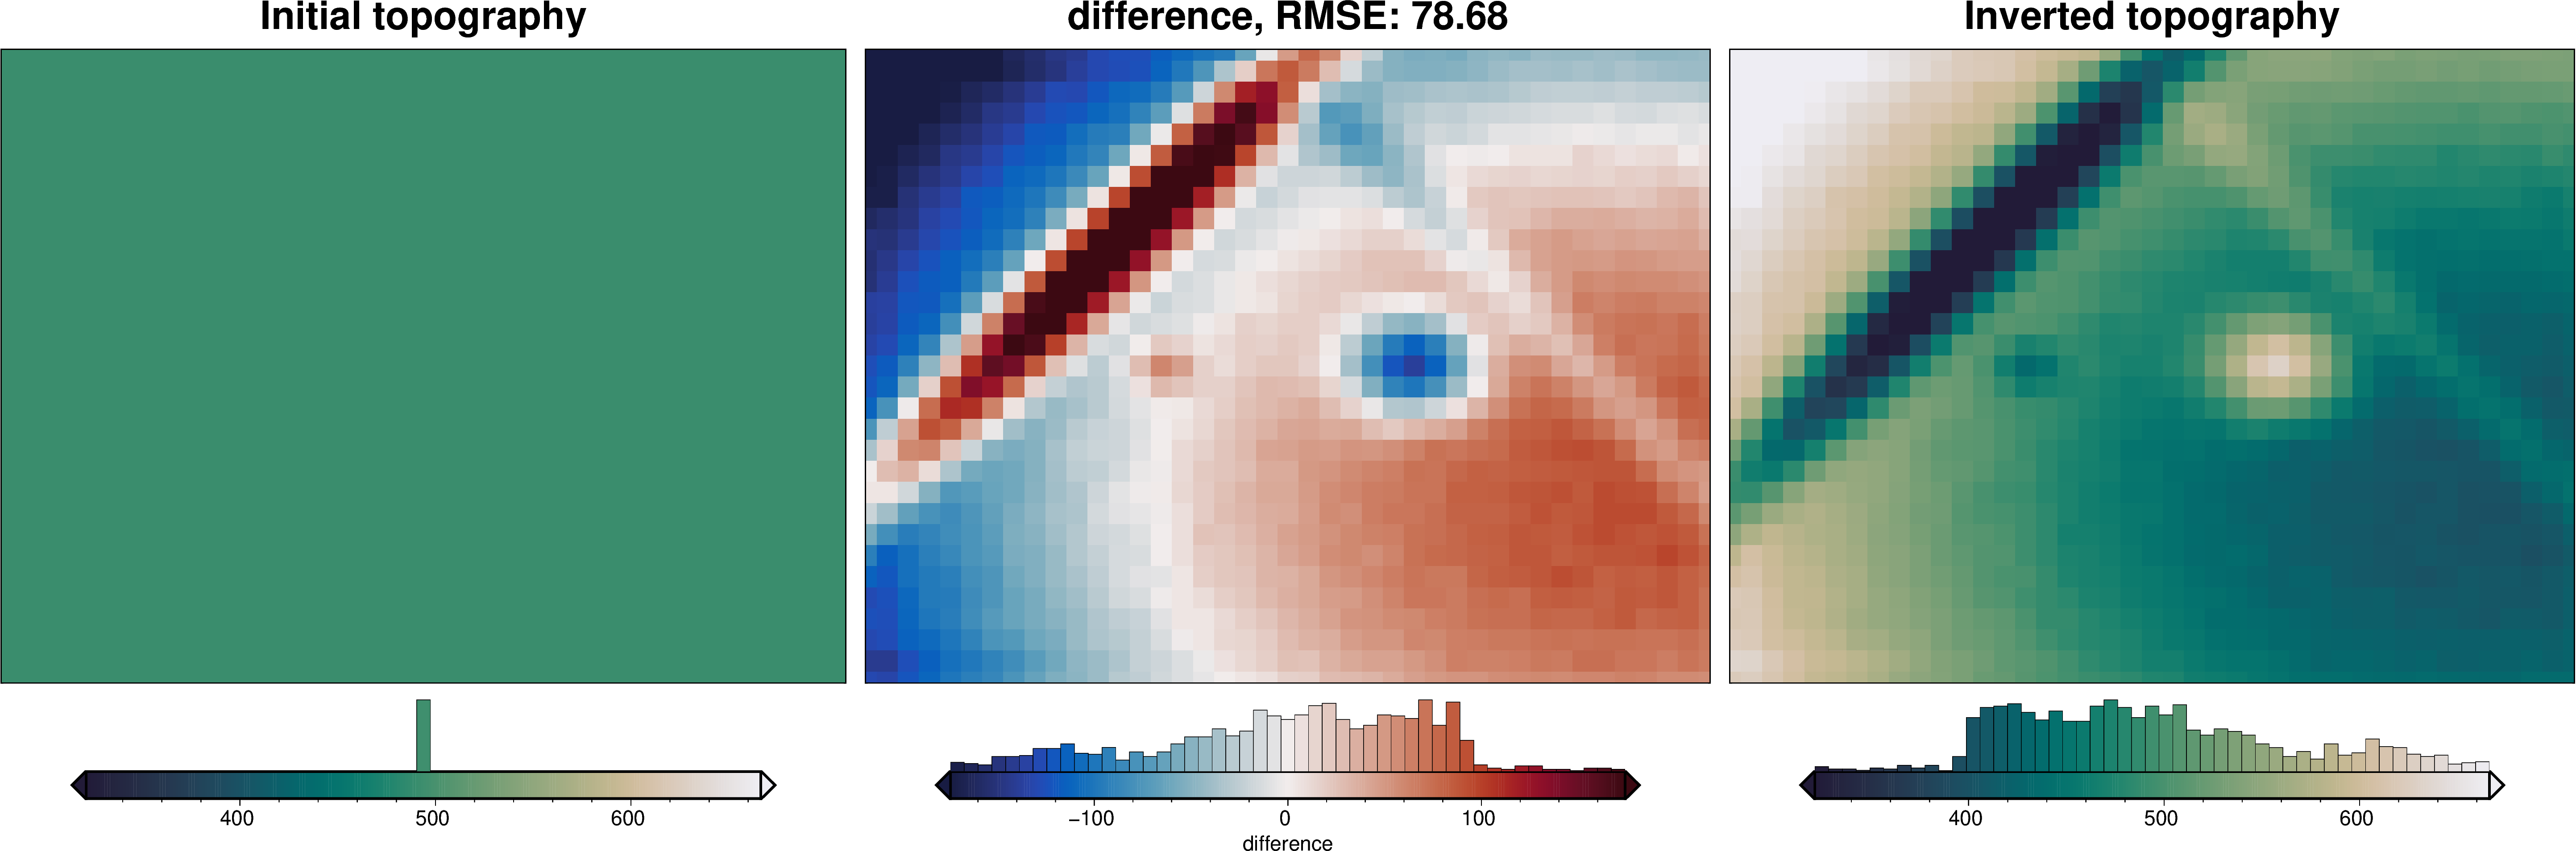

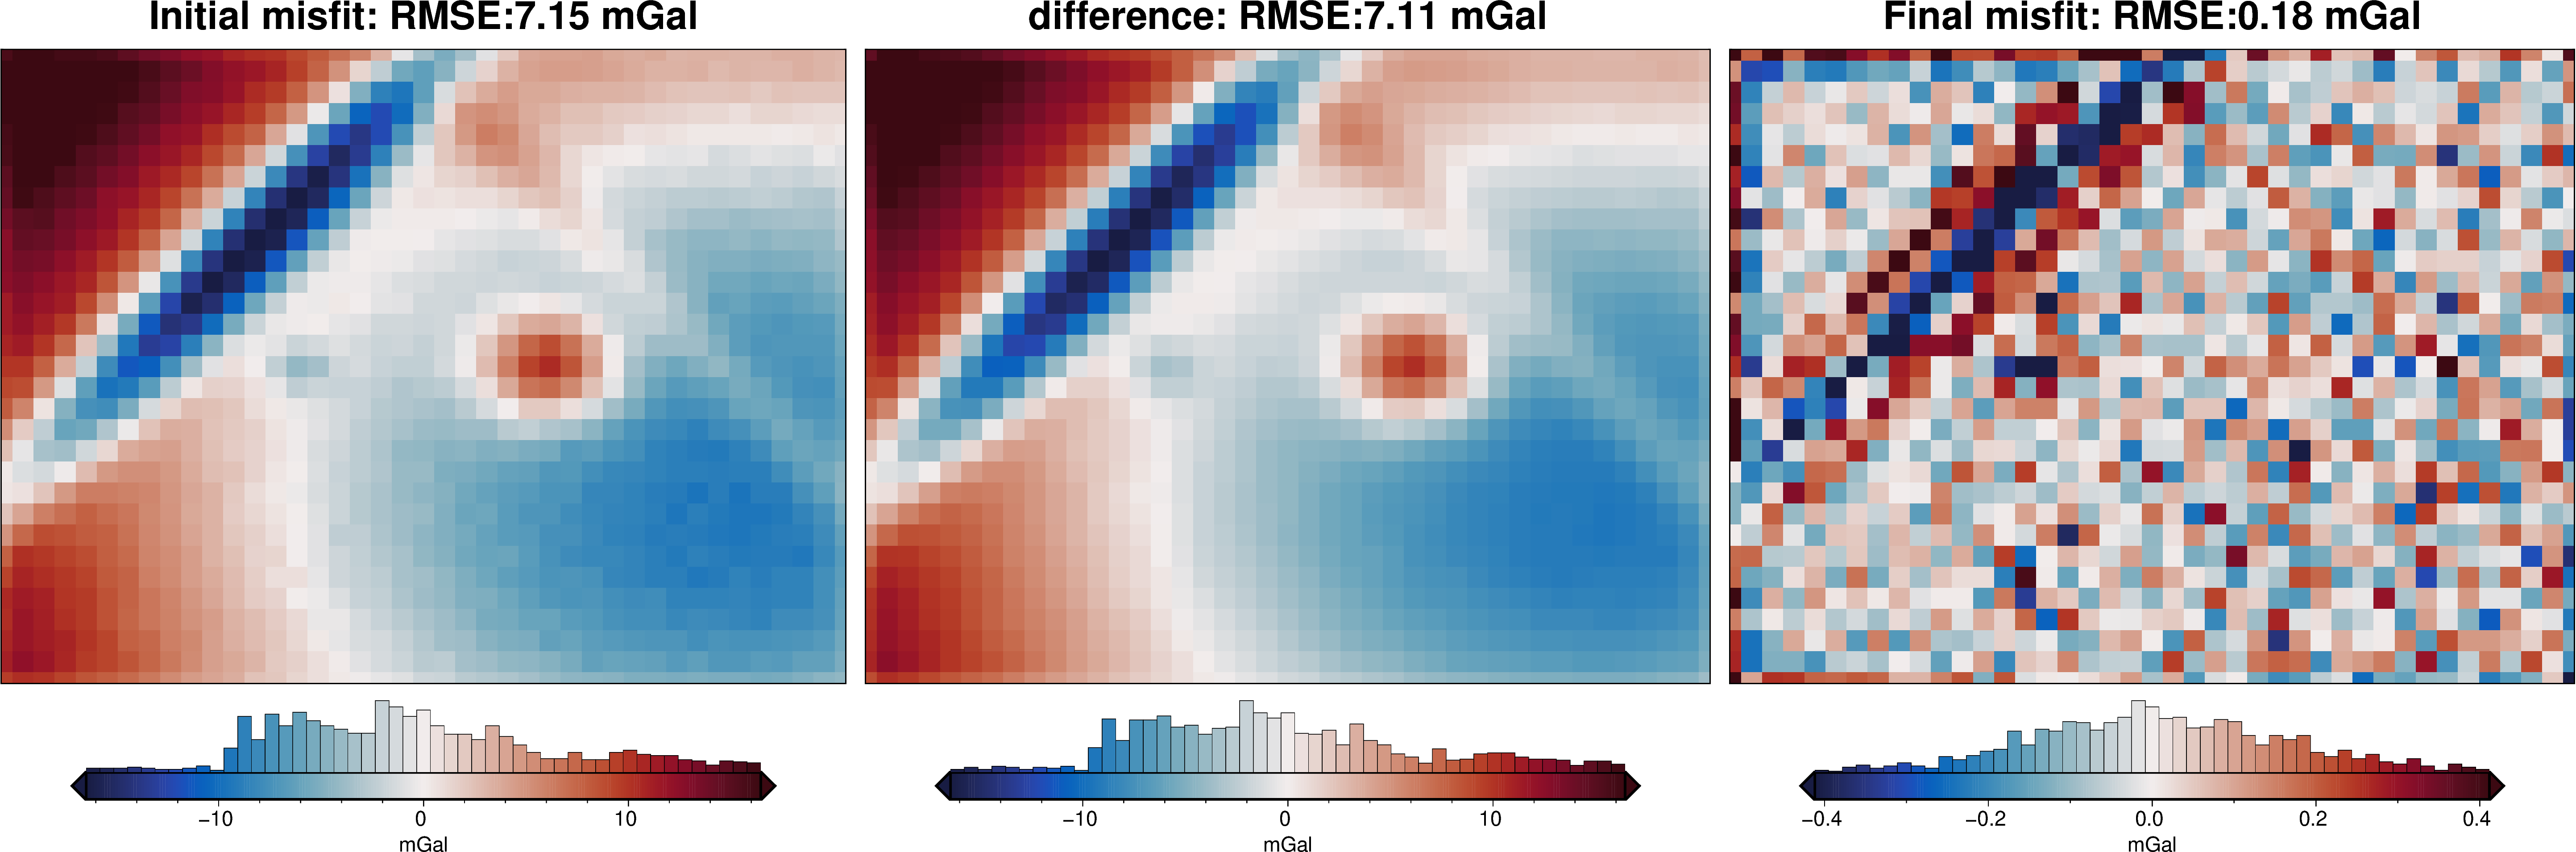

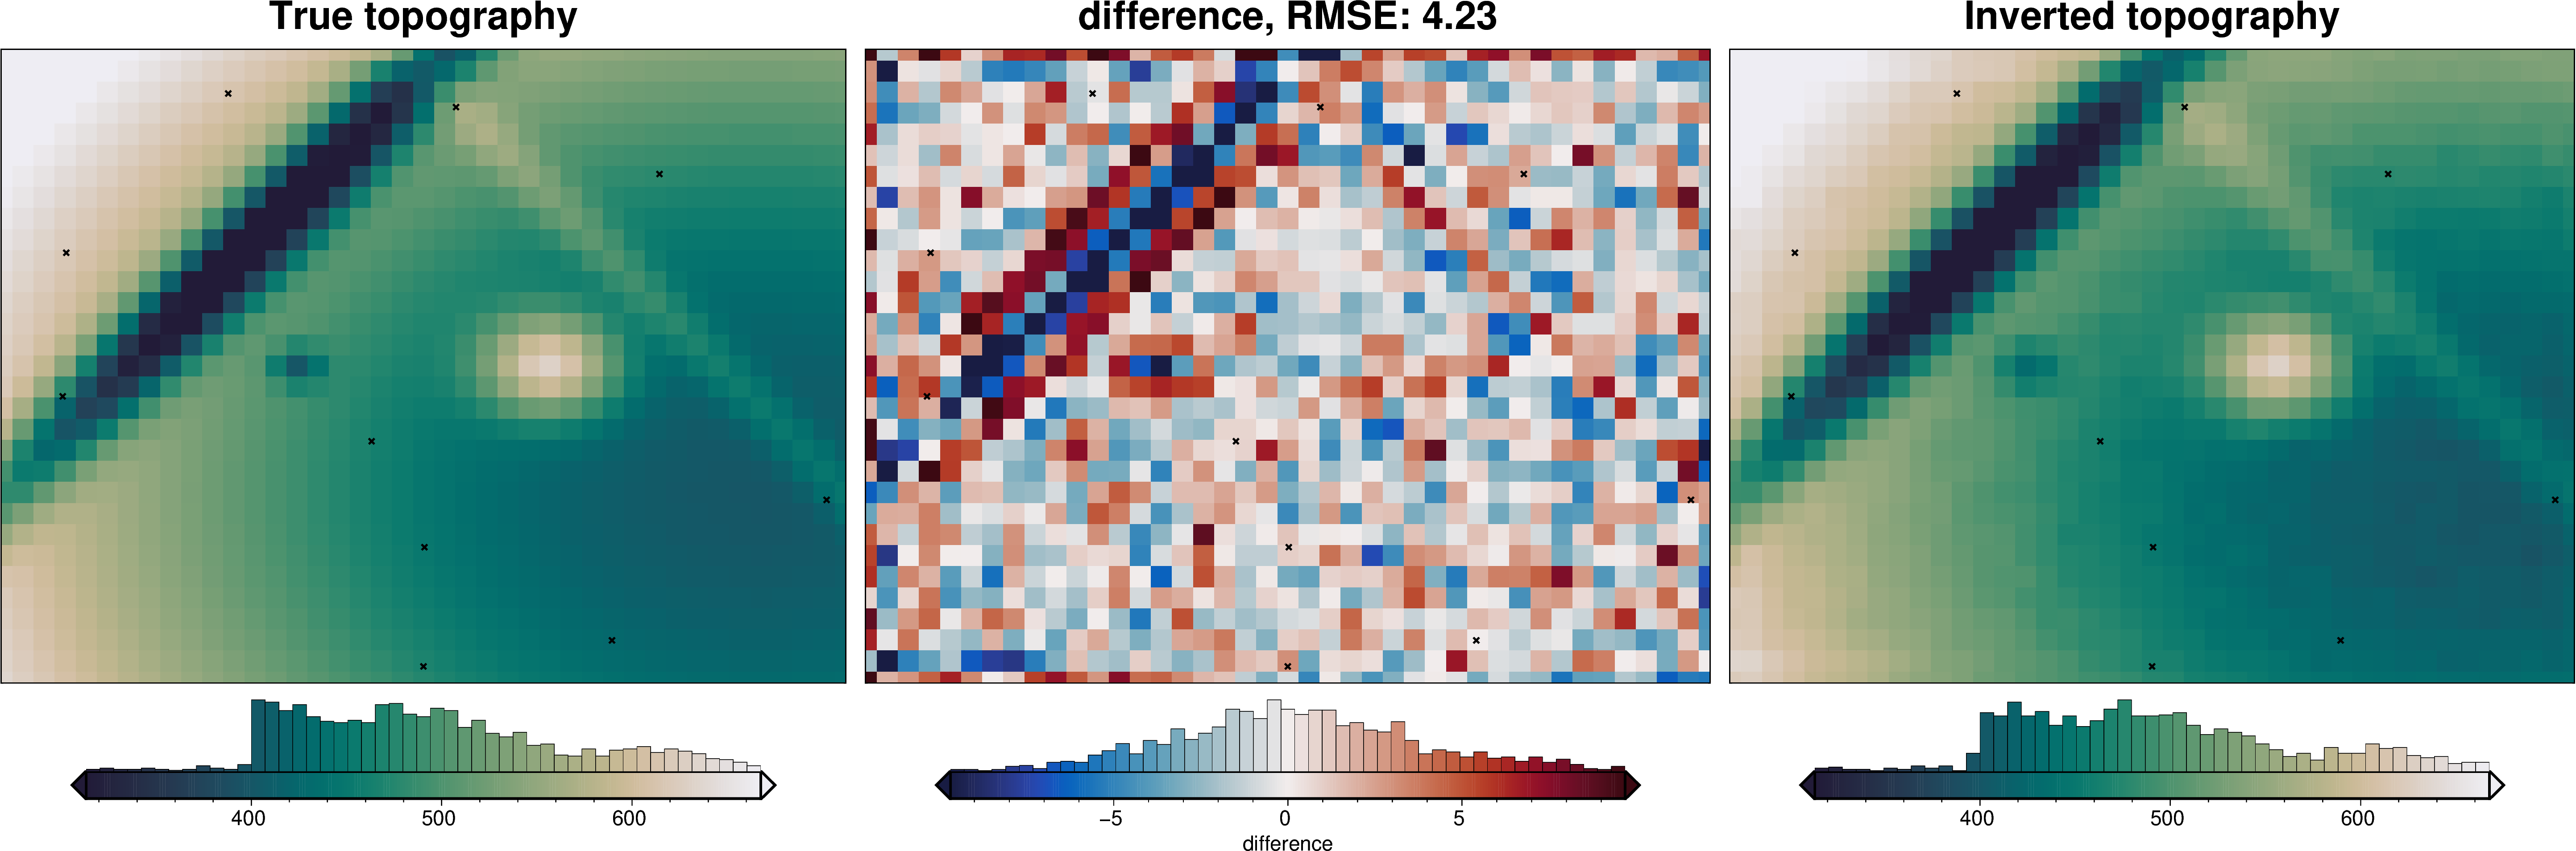

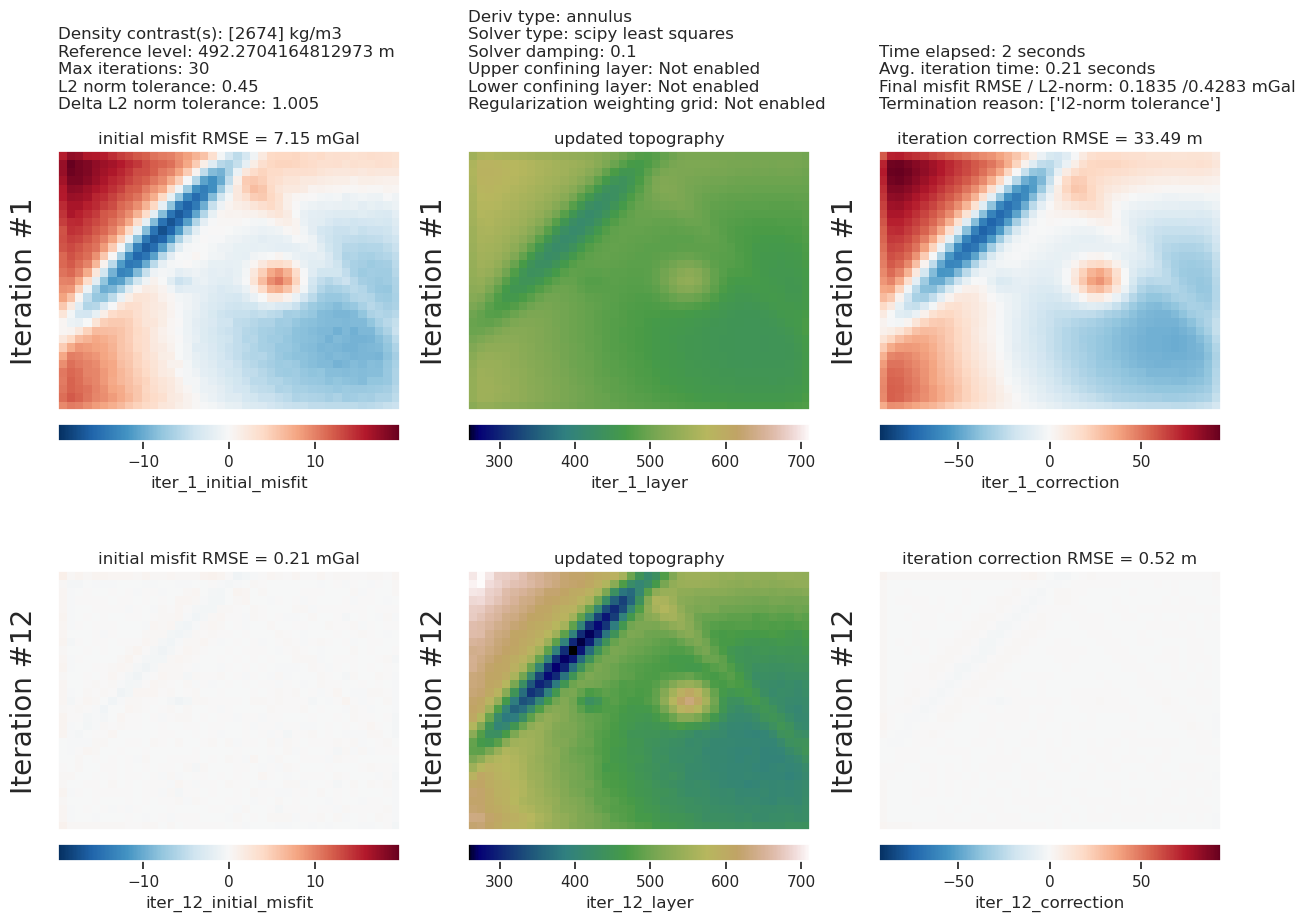

In [7]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.15c",
)

## Run inversion with poor choice of density contrast

In [8]:
# set Python's logging level
logging.getLogger().setLevel(logging.WARNING)

# set a bad reference level
bad_density_contrast = 4000

results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    starting_topography=starting_topography,
    density_contrast=bad_density_contrast,
    zref=true_zref,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    fname="../tmp/bad_density_contrast",
    **kwargs,
)
# collect the results
topo_results, grav_results, parameters, elapsed_time = results

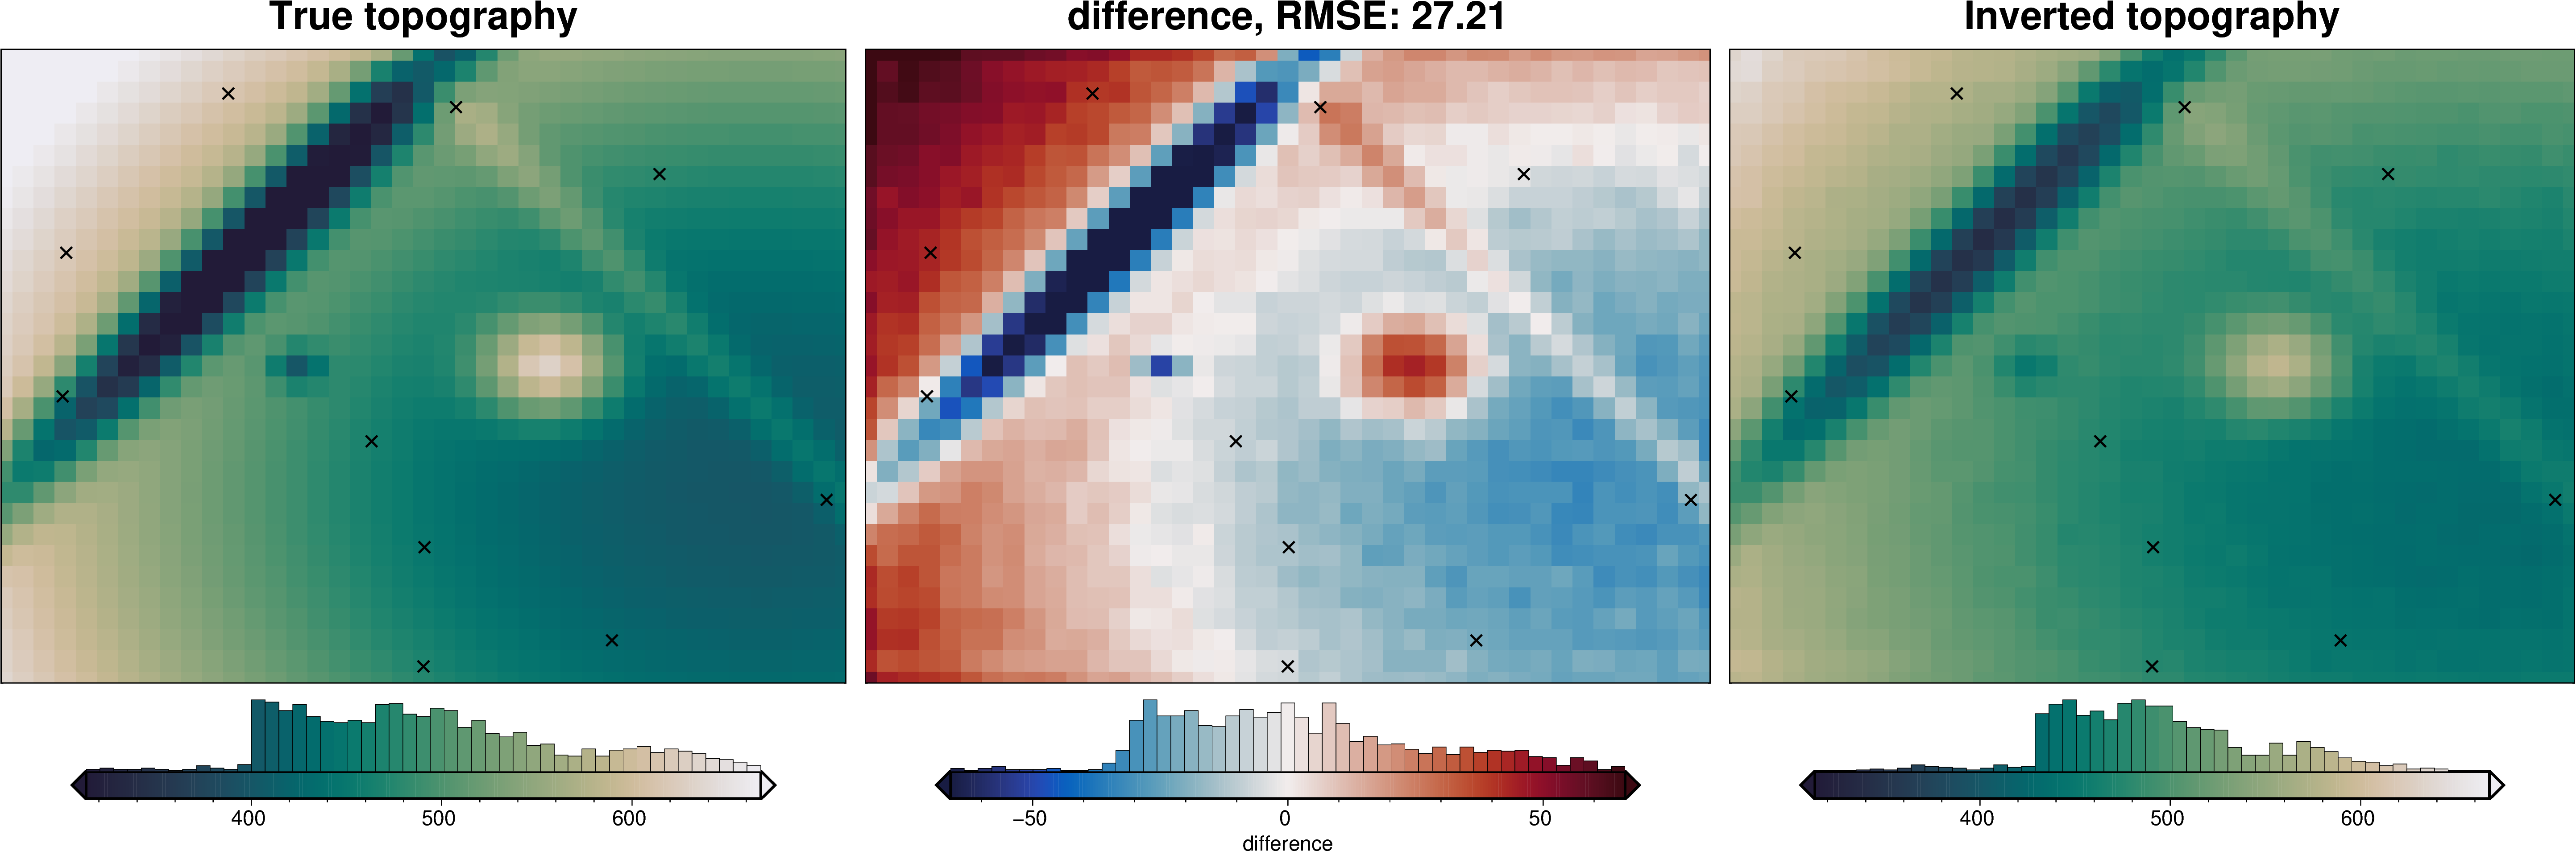

In [9]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

This inversion with a density contrast (4000) instead of the optimal density contrast of ~2670, shows that too high of a density contrast will result in a subdued topography, even though the misfit is minimized equally well. This depicts the non-uniqueness of this style of gravity inversion.